# Classification with PyTorch

This tutorial covers binary and multi-class classification using PyTorch, including neural network architectures, loss functions, and evaluation techniques.

## 1. Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris, load_wine
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Device-agnostic setup
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using CUDA: {torch.cuda.get_device_name()}")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using MPS (Apple Silicon)")
else:
    device = torch.device('cpu')
    print("Using CPU")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using CPU
PyTorch version: 2.8.0+cu126
Device: cpu


## 2. Binary Classification Model

Let's start with a simple binary classification model.

In [2]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # No activation here, we'll use BCEWithLogitsLoss
        return x

# Test the model structure
model = BinaryClassifier(input_size=2, hidden_size=64)
print(f"Model: {model}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

Model: BinaryClassifier(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
Total parameters: 2305


## 3. Generate Binary Classification Data

Binary data shapes: X=(1000, 2), y=(1000,)
Class distribution: [500 500]


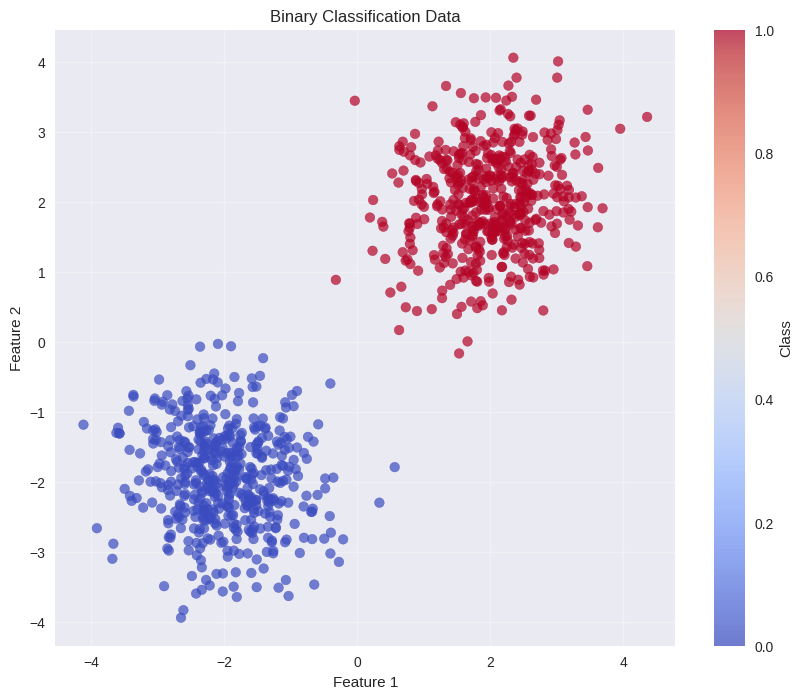


Tensor shapes:
Training: X=torch.Size([800, 2]), y=torch.Size([800, 1])
Test: X=torch.Size([200, 2]), y=torch.Size([200, 1])


In [3]:
def generate_binary_data(n_samples=1000, n_features=2, noise=0.1):
    """Generate synthetic binary classification data"""
    np.random.seed(42)

    # Create two clusters
    cluster1 = np.random.multivariate_normal([2, 2], [[0.5, 0.1], [0.1, 0.5]], n_samples//2)
    cluster2 = np.random.multivariate_normal([-2, -2], [[0.5, -0.1], [-0.1, 0.5]], n_samples//2)

    X = np.vstack([cluster1, cluster2])
    y = np.hstack([np.ones(n_samples//2), np.zeros(n_samples//2)])

    # Add noise
    X += noise * np.random.randn(*X.shape)

    return X, y

# Generate data
X_binary, y_binary = generate_binary_data(n_samples=1000)

print(f"Binary data shapes: X={X_binary.shape}, y={y_binary.shape}")
print(f"Class distribution: {np.bincount(y_binary.astype(int))}")

# Visualize the data
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_binary[:, 0], X_binary[:, 1], c=y_binary, cmap='coolwarm', alpha=0.7)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Binary Classification Data')
plt.colorbar(scatter, label='Class')
plt.grid(True, alpha=0.3)
plt.show()

# Split data
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_binary, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

# Standardize features
scaler_bin = StandardScaler()
X_train_bin_scaled = scaler_bin.fit_transform(X_train_bin)
X_test_bin_scaled = scaler_bin.transform(X_test_bin)

# Convert to tensors and move to device
X_train_bin_tensor = torch.FloatTensor(X_train_bin_scaled).to(device)
X_test_bin_tensor = torch.FloatTensor(X_test_bin_scaled).to(device)
y_train_bin_tensor = torch.FloatTensor(y_train_bin).reshape(-1, 1).to(device)
y_test_bin_tensor = torch.FloatTensor(y_test_bin).reshape(-1, 1).to(device)

print(f"\nTensor shapes:")
print(f"Training: X={X_train_bin_tensor.shape}, y={y_train_bin_tensor.shape}")
print(f"Test: X={X_test_bin_tensor.shape}, y={y_test_bin_tensor.shape}")

## 4. Training Function for Classification

In [4]:
def train_classifier(model, X_train, y_train, X_val, y_val,
                    optimizer, criterion, num_epochs=1000, print_every=100):
    """
    Train the classification model and return training history
    """
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    model.train()

    for epoch in range(num_epochs):
        # Forward pass
        y_pred_train = model(X_train)
        train_loss = criterion(y_pred_train, y_train)

        # Backward pass
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Calculate training accuracy
        with torch.no_grad():
            if y_train.shape[1] == 1:  # Binary classification
                train_pred_probs = torch.sigmoid(y_pred_train)
                train_pred_classes = (train_pred_probs > 0.5).float()
            else:  # Multi-class classification
                train_pred_classes = torch.argmax(y_pred_train, dim=1, keepdim=True)
                y_train_classes = torch.argmax(y_train, dim=1, keepdim=True)

            train_acc = (train_pred_classes == y_train).float().mean().item() if y_train.shape[1] == 1 else (train_pred_classes == y_train_classes).float().mean().item()

        # Validation
        model.eval()
        with torch.no_grad():
            y_pred_val = model(X_val)
            val_loss = criterion(y_pred_val, y_val)

            if y_val.shape[1] == 1:  # Binary classification
                val_pred_probs = torch.sigmoid(y_pred_val)
                val_pred_classes = (val_pred_probs > 0.5).float()
            else:  # Multi-class classification
                val_pred_classes = torch.argmax(y_pred_val, dim=1, keepdim=True)
                y_val_classes = torch.argmax(y_val, dim=1, keepdim=True)

            val_acc = (val_pred_classes == y_val).float().mean().item() if y_val.shape[1] == 1 else (val_pred_classes == y_val_classes).float().mean().item()

        model.train()

        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{num_epochs}], '
                  f'Train Loss: {train_loss.item():.4f}, Train Acc: {train_acc:.4f}, '
                  f'Val Loss: {val_loss.item():.4f}, Val Acc: {val_acc:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

def evaluate_classifier(model, X_test, y_test, class_names=None, binary=True):
    """
    Evaluate classification model performance
    """
    model.eval()
    with torch.no_grad():
        y_pred_logits = model(X_test)

        if binary:
            y_pred_probs = torch.sigmoid(y_pred_logits)
            y_pred_classes = (y_pred_probs > 0.5).float()
            y_test_classes = y_test
        else:
            y_pred_probs = F.softmax(y_pred_logits, dim=1)
            y_pred_classes = torch.argmax(y_pred_logits, dim=1)
            y_test_classes = torch.argmax(y_test, dim=1)

        # Move to CPU for sklearn metrics
        y_test_cpu = y_test_classes.cpu().numpy().flatten()
        y_pred_cpu = y_pred_classes.cpu().numpy().flatten()

        accuracy = accuracy_score(y_test_cpu, y_pred_cpu)

        if binary:
            precision, recall, f1, _ = precision_recall_fscore_support(
                y_test_cpu, y_pred_cpu, average='binary'
            )
        else:
            precision, recall, f1, _ = precision_recall_fscore_support(
                y_test_cpu, y_pred_cpu, average='weighted'
            )

        cm = confusion_matrix(y_test_cpu, y_pred_cpu)

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")

        return accuracy, precision, recall, f1, cm, y_pred_probs

## 5. Train Binary Classifier

In [5]:
# Split training data for validation
X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(
    X_train_bin_tensor.cpu().numpy(), y_train_bin_tensor.cpu().numpy(),
    test_size=0.2, random_state=42, stratify=y_train_bin_tensor.cpu().numpy()
)

# Convert back to tensors
X_train_b = torch.FloatTensor(X_train_b).to(device)
X_val_b = torch.FloatTensor(X_val_b).to(device)
y_train_b = torch.FloatTensor(y_train_b).reshape(-1, 1).to(device)
y_val_b = torch.FloatTensor(y_val_b).reshape(-1, 1).to(device)

# Initialize model, loss function, and optimizer
binary_model = BinaryClassifier(input_size=2, hidden_size=64).to(device)
binary_criterion = nn.BCEWithLogitsLoss()  # Combines sigmoid + BCE
binary_optimizer = optim.Adam(binary_model.parameters(), lr=0.001)

print(f"Binary model parameters: {sum(p.numel() for p in binary_model.parameters())}")

# Train the model
binary_train_losses, binary_val_losses, binary_train_accs, binary_val_accs = train_classifier(
    binary_model, X_train_b, y_train_b, X_val_b, y_val_b,
    binary_optimizer, binary_criterion, num_epochs=800, print_every=200
)

Binary model parameters: 2305
Epoch [0/800], Train Loss: 0.6450, Train Acc: 0.5203, Val Loss: 0.6330, Val Acc: 0.5000
Epoch [200/800], Train Loss: 0.0049, Train Acc: 1.0000, Val Loss: 0.0034, Val Acc: 1.0000
Epoch [400/800], Train Loss: 0.0011, Train Acc: 1.0000, Val Loss: 0.0009, Val Acc: 1.0000
Epoch [600/800], Train Loss: 0.0006, Train Acc: 1.0000, Val Loss: 0.0006, Val Acc: 1.0000


## 6. Visualize Binary Classification Results

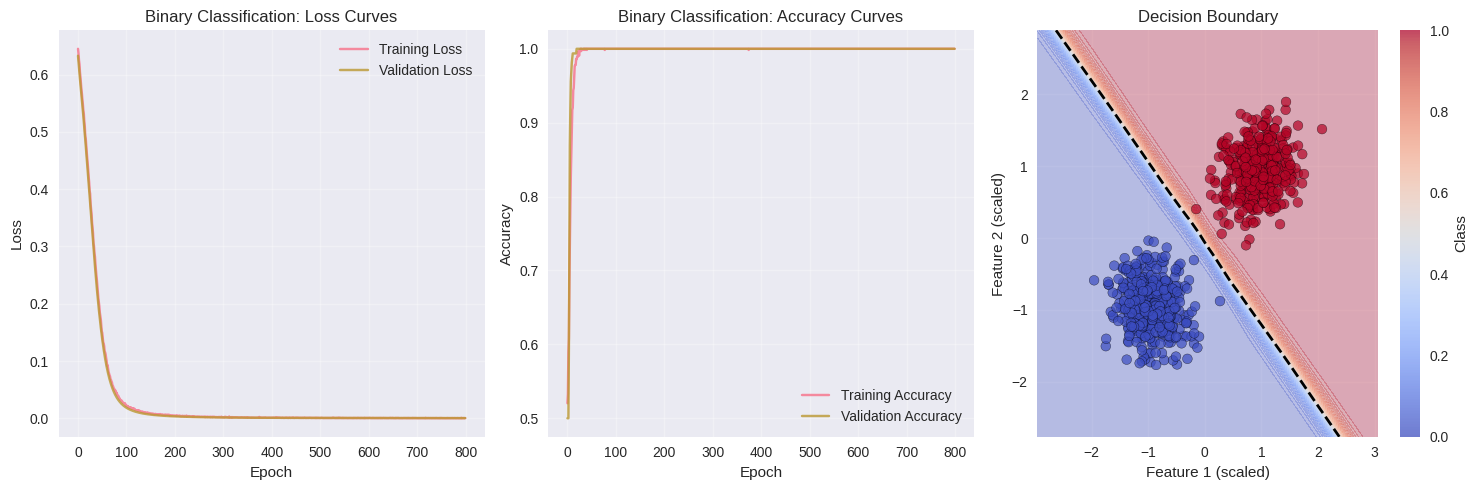

In [6]:
# Plot training curves
plt.figure(figsize=(15, 5))

# Loss curves
plt.subplot(1, 3, 1)
plt.plot(binary_train_losses, label='Training Loss', alpha=0.8)
plt.plot(binary_val_losses, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Binary Classification: Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy curves
plt.subplot(1, 3, 2)
plt.plot(binary_train_accs, label='Training Accuracy', alpha=0.8)
plt.plot(binary_val_accs, label='Validation Accuracy', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Binary Classification: Accuracy Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# Decision boundary visualization
plt.subplot(1, 3, 3)

# Create a mesh
h = 0.02
x_min, x_max = X_train_bin_scaled[:, 0].min() - 1, X_train_bin_scaled[:, 0].max() + 1
y_min, y_max = X_train_bin_scaled[:, 1].min() - 1, X_train_bin_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Make predictions on the mesh
mesh_points = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)
binary_model.eval()
with torch.no_grad():
    mesh_pred = torch.sigmoid(binary_model(mesh_points))
    mesh_pred = mesh_pred.cpu().numpy().reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, mesh_pred, levels=50, alpha=0.3, cmap='coolwarm')
plt.contour(xx, yy, mesh_pred, levels=[0.5], colors='black', linestyles='--', linewidths=2)

# Plot data points
scatter = plt.scatter(X_train_bin_scaled[:, 0], X_train_bin_scaled[:, 1],
                     c=y_train_bin, cmap='coolwarm', alpha=0.7, edgecolors='black')
plt.xlabel('Feature 1 (scaled)')
plt.ylabel('Feature 2 (scaled)')
plt.title('Decision Boundary')
plt.colorbar(scatter, label='Class')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Evaluate Binary Classifier

Binary Classification Test Results:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


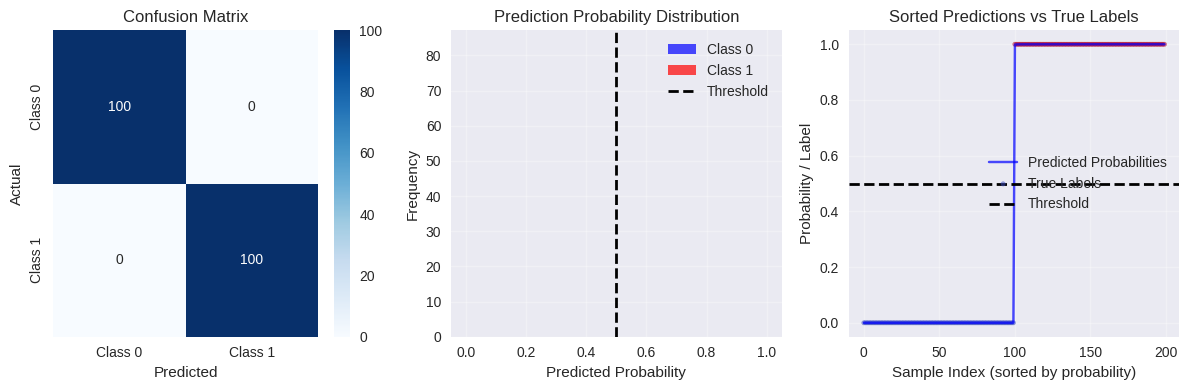

In [7]:
# Evaluate on test set
print("Binary Classification Test Results:")
print("=" * 40)
acc, prec, rec, f1, cm, probs = evaluate_classifier(
    binary_model, X_test_bin_tensor, y_test_bin_tensor, binary=True
)

# Plot confusion matrix
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Plot prediction probabilities histogram
plt.subplot(1, 3, 2)
probs_cpu = probs.cpu().numpy().flatten()
y_test_cpu = y_test_bin_tensor.cpu().numpy().flatten()

plt.hist(probs_cpu[y_test_cpu == 0], bins=30, alpha=0.7, label='Class 0', color='blue')
plt.hist(probs_cpu[y_test_cpu == 1], bins=30, alpha=0.7, label='Class 1', color='red')
plt.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Prediction Probability Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot ROC-like curve (predicted probabilities)
plt.subplot(1, 3, 3)
sorted_indices = np.argsort(probs_cpu)
sorted_probs = probs_cpu[sorted_indices]
sorted_labels = y_test_cpu[sorted_indices]

plt.plot(sorted_probs, color='blue', alpha=0.7, label='Predicted Probabilities')
plt.scatter(range(len(sorted_labels)), sorted_labels,
           c=sorted_labels, cmap='coolwarm', alpha=0.5, s=10, label='True Labels')
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
plt.xlabel('Sample Index (sorted by probability)')
plt.ylabel('Probability / Label')
plt.title('Sorted Predictions vs True Labels')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Multi-Class Classification: Iris Dataset

Now let's work with the classic Iris dataset for multi-class classification.

Iris dataset: X=(150, 4), y=(150,)
Classes: ['setosa' 'versicolor' 'virginica']
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Class distribution: [50 50 50]


<Figure size 1200x800 with 0 Axes>

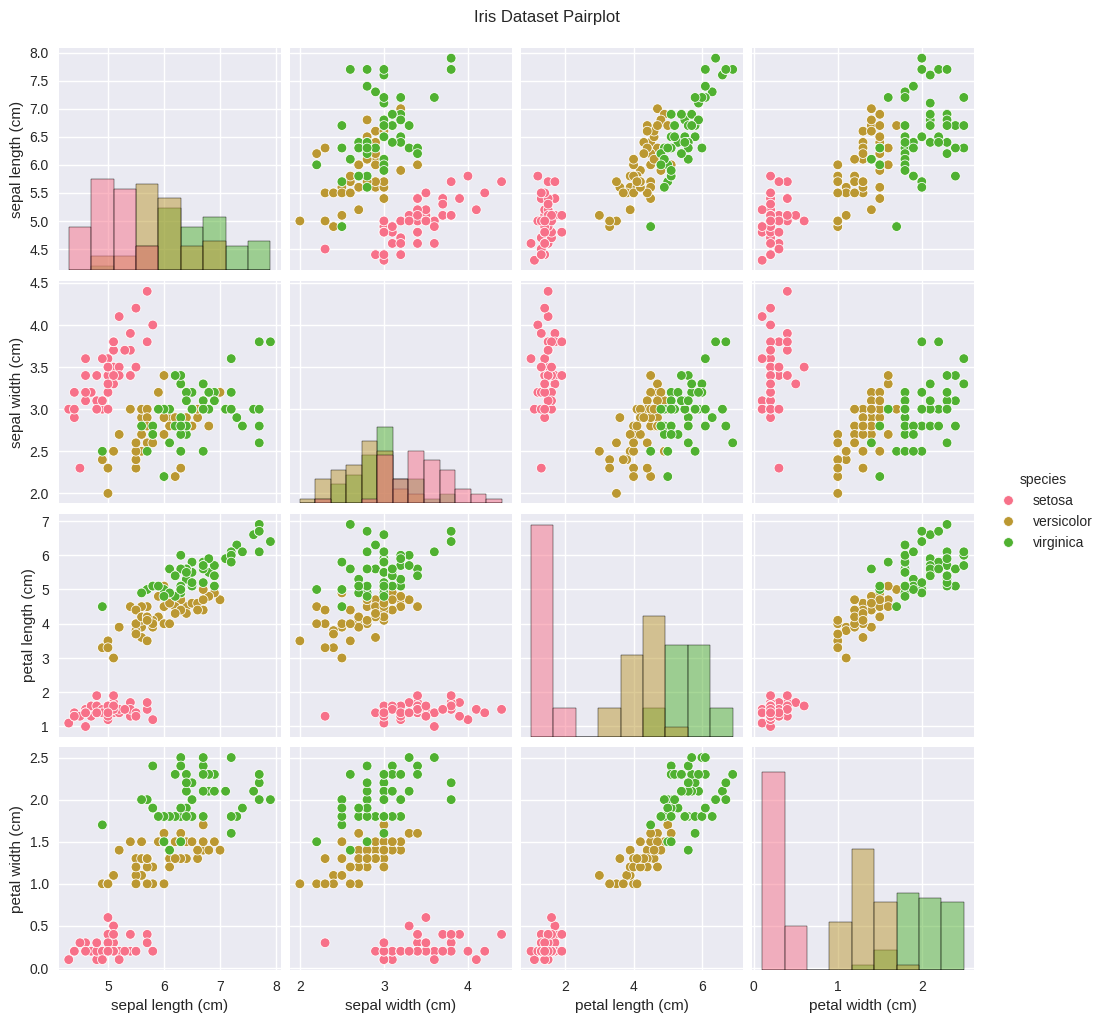

In [8]:
class MultiClassClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MultiClassClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # No activation, we'll use CrossEntropyLoss
        return x

# Load Iris dataset
iris = load_iris()
X_iris, y_iris = iris.data, iris.target
class_names = iris.target_names

print(f"Iris dataset: X={X_iris.shape}, y={y_iris.shape}")
print(f"Classes: {class_names}")
print(f"Features: {iris.feature_names}")
print(f"Class distribution: {np.bincount(y_iris)}")

# Visualize the data
df_iris = pd.DataFrame(X_iris, columns=iris.feature_names)
df_iris['species'] = [class_names[i] for i in y_iris]

plt.figure(figsize=(12, 8))
sns.pairplot(df_iris, hue='species', diag_kind='hist', height=2.5)
plt.suptitle('Iris Dataset Pairplot', y=1.02)
plt.show()

In [9]:
# Prepare Iris data
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(
    X_iris, y_iris, test_size=0.2, random_state=42, stratify=y_iris
)

# Standardize features
scaler_iris = StandardScaler()
X_train_iris_scaled = scaler_iris.fit_transform(X_train_iris)
X_test_iris_scaled = scaler_iris.transform(X_test_iris)

# Split training data for validation
X_train_i, X_val_i, y_train_i, y_val_i = train_test_split(
    X_train_iris_scaled, y_train_iris, test_size=0.2, random_state=42, stratify=y_train_iris
)

# Convert to tensors and move to device
X_train_i_tensor = torch.FloatTensor(X_train_i).to(device)
X_val_i_tensor = torch.FloatTensor(X_val_i).to(device)
X_test_iris_tensor = torch.FloatTensor(X_test_iris_scaled).to(device)

y_train_i_tensor = torch.LongTensor(y_train_i).to(device)
y_val_i_tensor = torch.LongTensor(y_val_i).to(device)
y_test_iris_tensor = torch.LongTensor(y_test_iris).to(device)

print(f"Iris tensor shapes:")
print(f"Training: X={X_train_i_tensor.shape}, y={y_train_i_tensor.shape}")
print(f"Validation: X={X_val_i_tensor.shape}, y={y_val_i_tensor.shape}")
print(f"Test: X={X_test_iris_tensor.shape}, y={y_test_iris_tensor.shape}")

Iris tensor shapes:
Training: X=torch.Size([96, 4]), y=torch.Size([96])
Validation: X=torch.Size([24, 4]), y=torch.Size([24])
Test: X=torch.Size([30, 4]), y=torch.Size([30])


## 9. Train Multi-Class Classifier

In [10]:
# Initialize multi-class model
num_features = X_train_i_tensor.shape[1]
num_classes = len(class_names)

iris_model = MultiClassClassifier(input_size=num_features, hidden_size=64, num_classes=num_classes).to(device)
iris_criterion = nn.CrossEntropyLoss()
iris_optimizer = optim.Adam(iris_model.parameters(), lr=0.001)

print(f"Multi-class model parameters: {sum(p.numel() for p in iris_model.parameters())}")

# Modified training function for multi-class
def train_multiclass(model, X_train, y_train, X_val, y_val,
                    optimizer, criterion, num_epochs=1000, print_every=100):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    model.train()

    for epoch in range(num_epochs):
        # Forward pass
        y_pred_train = model(X_train)
        train_loss = criterion(y_pred_train, y_train)

        # Backward pass
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Calculate training accuracy
        with torch.no_grad():
            train_pred_classes = torch.argmax(y_pred_train, dim=1)
            train_acc = (train_pred_classes == y_train).float().mean().item()

        # Validation
        model.eval()
        with torch.no_grad():
            y_pred_val = model(X_val)
            val_loss = criterion(y_pred_val, y_val)
            val_pred_classes = torch.argmax(y_pred_val, dim=1)
            val_acc = (val_pred_classes == y_val).float().mean().item()
        model.train()

        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{num_epochs}], '
                  f'Train Loss: {train_loss.item():.4f}, Train Acc: {train_acc:.4f}, '
                  f'Val Loss: {val_loss.item():.4f}, Val Acc: {val_acc:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the multi-class model
iris_train_losses, iris_val_losses, iris_train_accs, iris_val_accs = train_multiclass(
    iris_model, X_train_i_tensor, y_train_i_tensor, X_val_i_tensor, y_val_i_tensor,
    iris_optimizer, iris_criterion, num_epochs=600, print_every=150
)

Multi-class model parameters: 2499
Epoch [0/600], Train Loss: 1.0887, Train Acc: 0.3646, Val Loss: 1.0756, Val Acc: 0.4167
Epoch [150/600], Train Loss: 0.1509, Train Acc: 0.9479, Val Loss: 0.1420, Val Acc: 0.9583
Epoch [300/600], Train Loss: 0.0926, Train Acc: 0.9688, Val Loss: 0.0991, Val Acc: 0.9583
Epoch [450/600], Train Loss: 0.0432, Train Acc: 0.9792, Val Loss: 0.1007, Val Acc: 0.9583


## 10. Evaluate Multi-Class Classifier

In [11]:
# Evaluate on test set
iris_model.eval()
with torch.no_grad():
    y_pred_iris_logits = iris_model(X_test_iris_tensor)
    y_pred_iris_probs = F.softmax(y_pred_iris_logits, dim=1)
    y_pred_iris_classes = torch.argmax(y_pred_iris_logits, dim=1)

# Move to CPU for sklearn metrics
y_test_iris_cpu = y_test_iris_tensor.cpu().numpy()
y_pred_iris_cpu = y_pred_iris_classes.cpu().numpy()

# Calculate metrics
accuracy = accuracy_score(y_test_iris_cpu, y_pred_iris_cpu)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test_iris_cpu, y_pred_iris_cpu, average='weighted'
)
cm = confusion_matrix(y_test_iris_cpu, y_pred_iris_cpu)

print("Iris Multi-Class Classification Results:")
print("=" * 45)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test_iris_cpu, y_pred_iris_cpu, target_names=class_names))

Iris Multi-Class Classification Results:
Accuracy: 0.9667
Precision (weighted): 0.9697
Recall (weighted): 0.9667
F1-Score (weighted): 0.9666

Detailed Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



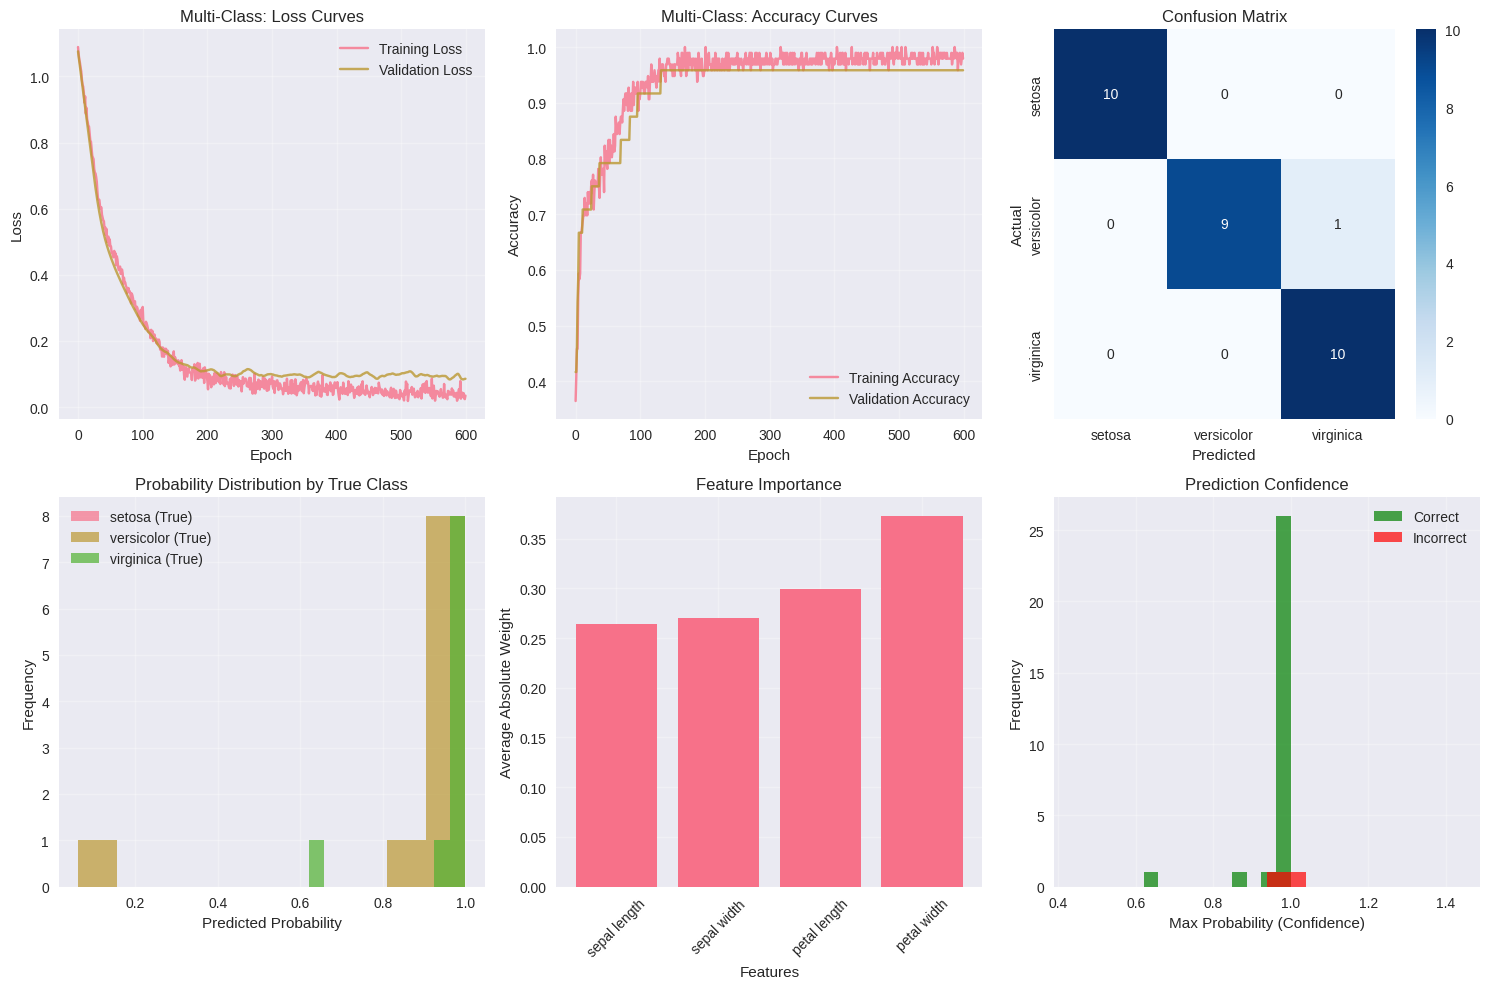

In [12]:
# Visualize multi-class results
plt.figure(figsize=(15, 10))

# Training curves
plt.subplot(2, 3, 1)
plt.plot(iris_train_losses, label='Training Loss', alpha=0.8)
plt.plot(iris_val_losses, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Multi-Class: Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.plot(iris_train_accs, label='Training Accuracy', alpha=0.8)
plt.plot(iris_val_accs, label='Validation Accuracy', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Multi-Class: Accuracy Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# Confusion matrix
plt.subplot(2, 3, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Class probability distributions
plt.subplot(2, 3, 4)
probs_cpu = y_pred_iris_probs.cpu().numpy()
for i, class_name in enumerate(class_names):
    class_probs = probs_cpu[y_test_iris_cpu == i, i]
    plt.hist(class_probs, bins=10, alpha=0.7, label=f'{class_name} (True)')

plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution by True Class')
plt.legend()
plt.grid(True, alpha=0.3)

# Feature importance (weights from first layer)
plt.subplot(2, 3, 5)
weights = iris_model.fc1.weight.data.cpu().numpy()
feature_importance = np.abs(weights).mean(axis=0)
plt.bar(range(len(iris.feature_names)), feature_importance)
plt.xlabel('Features')
plt.ylabel('Average Absolute Weight')
plt.title('Feature Importance')
plt.xticks(range(len(iris.feature_names)),
           [name.replace(' (cm)', '') for name in iris.feature_names], rotation=45)
plt.grid(True, alpha=0.3)

# Prediction confidence
plt.subplot(2, 3, 6)
max_probs = np.max(probs_cpu, axis=1)
correct_predictions = (y_pred_iris_cpu == y_test_iris_cpu)

plt.hist(max_probs[correct_predictions], bins=10, alpha=0.7,
         label='Correct', color='green')
plt.hist(max_probs[~correct_predictions], bins=10, alpha=0.7,
         label='Incorrect', color='red')
plt.xlabel('Max Probability (Confidence)')
plt.ylabel('Frequency')
plt.title('Prediction Confidence')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Key Takeaways

In this tutorial, we covered:

1. **Binary Classification**: Using BCEWithLogitsLoss and sigmoid activation
2. **Multi-Class Classification**: Using CrossEntropyLoss and softmax activation
3. **Neural Network Architecture**: Multi-layer networks with ReLU and Dropout
4. **Device-Agnostic Code**: All models and tensors work on CPU, CUDA, or MPS
5. **Evaluation Metrics**: Accuracy, Precision, Recall, F1-Score, Confusion Matrix
6. **Visualization**: Decision boundaries, training curves, probability distributions
7. **Data Preprocessing**: Feature scaling and train/validation/test splits
8. **Model Analysis**: Feature importance and prediction confidence

## Best Practices Learned

- Use appropriate loss functions: BCEWithLogitsLoss for binary, CrossEntropyLoss for multi-class
- Always standardize input features
- Use stratified splitting to maintain class balance
- Monitor both loss and accuracy during training
- Evaluate with multiple metrics, not just accuracy
- Visualize confusion matrices and probability distributions
- Use dropout for regularization
- Write device-agnostic code for portability

## Common Pitfalls to Avoid

- Don't use sigmoid/softmax with CrossEntropyLoss (it's included)
- Don't forget to call `.eval()` during evaluation
- Watch out for class imbalance in real datasets
- Always use proper train/validation/test splits

## Next Steps

- Proceed to 04_cnn for image classification with CNNs
- Learn about regularization techniques (L1, L2, Dropout)
- Explore advanced architectures and transfer learning
- Study techniques for handling imbalanced datasets